In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
from torchvision import transforms, models
import torch
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_default.xml')

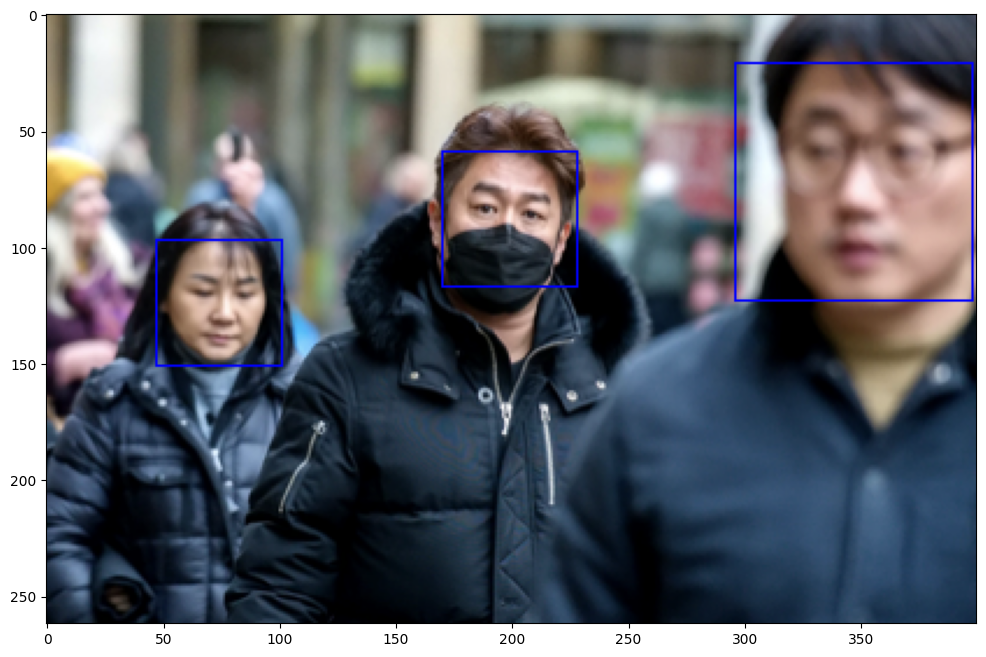

In [21]:
#trying it out on a sample image
img = cv2.imread('./faca_data/images/maksssksksss244.png')
#img = cv2.imread('./faca_data/images/maksssksksss145.png')
if img is None:
    print("Image not loaded")
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [3]:
MIN_DISTANCE = 130

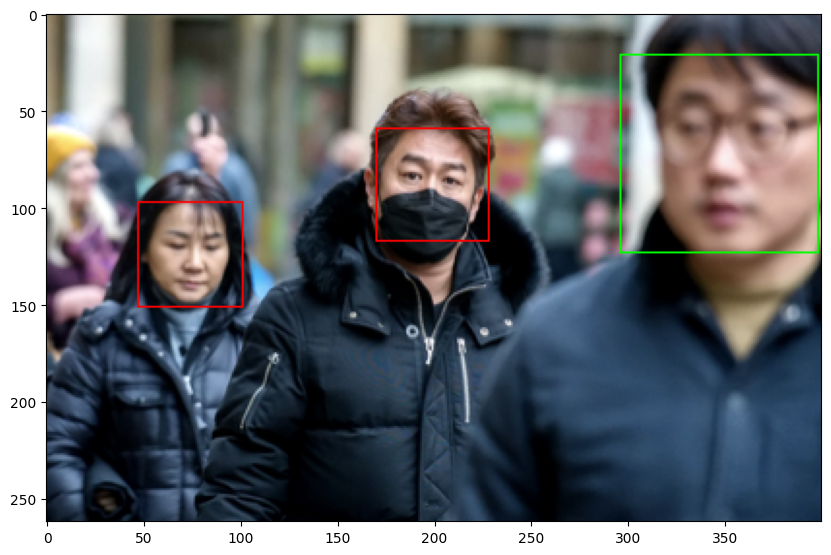

In [22]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

In [10]:
import tritonclient.grpc as grpcclient
from tritonclient.grpc import InferInput, InferRequestedOutput
triton_client = grpcclient.InferenceServerClient(url='triton-triton-inference-server:8001', verbose=0)
#model info
model_info = {'name': 'vgg19_face',
              'version': '1', }
              
#check cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')
# # Get model metadata
# metadata = triton_client.get_model_metadata(model_name=model_info['name'], model_version=model_info['version'])
# # Print the metadata
# print("Model Metadata:")
# print(metadata)
print('*'*50)
config = triton_client.get_model_config(model_name=model_info['name'], model_version=model_info['version'])
print("Model Config:")
print(config)

cuda:0 is available!

**************************************************
Model Config:
config {
  name: "vgg19_face"
  platform: "pytorch_libtorch"
  version_policy {
    latest {
      num_versions: 1
    }
  }
  input {
    name: "input__0"
    data_type: TYPE_FP32
    dims: 3
    dims: 224
    dims: 224
    reshape {
      shape: 1
      shape: 3
      shape: 224
      shape: 224
    }
  }
  output {
    name: "output__0"
    data_type: TYPE_FP32
    dims: 1
    dims: 2
  }
  instance_group {
    name: "vgg19_face"
    count: 1
    gpus: 0
    kind: KIND_GPU
  }
  default_model_filename: "model.pt"
  optimization {
    input_pinned_memory {
      enable: true
    }
    output_pinned_memory {
      enable: true
    }
  }
  backend: "pytorch"
}



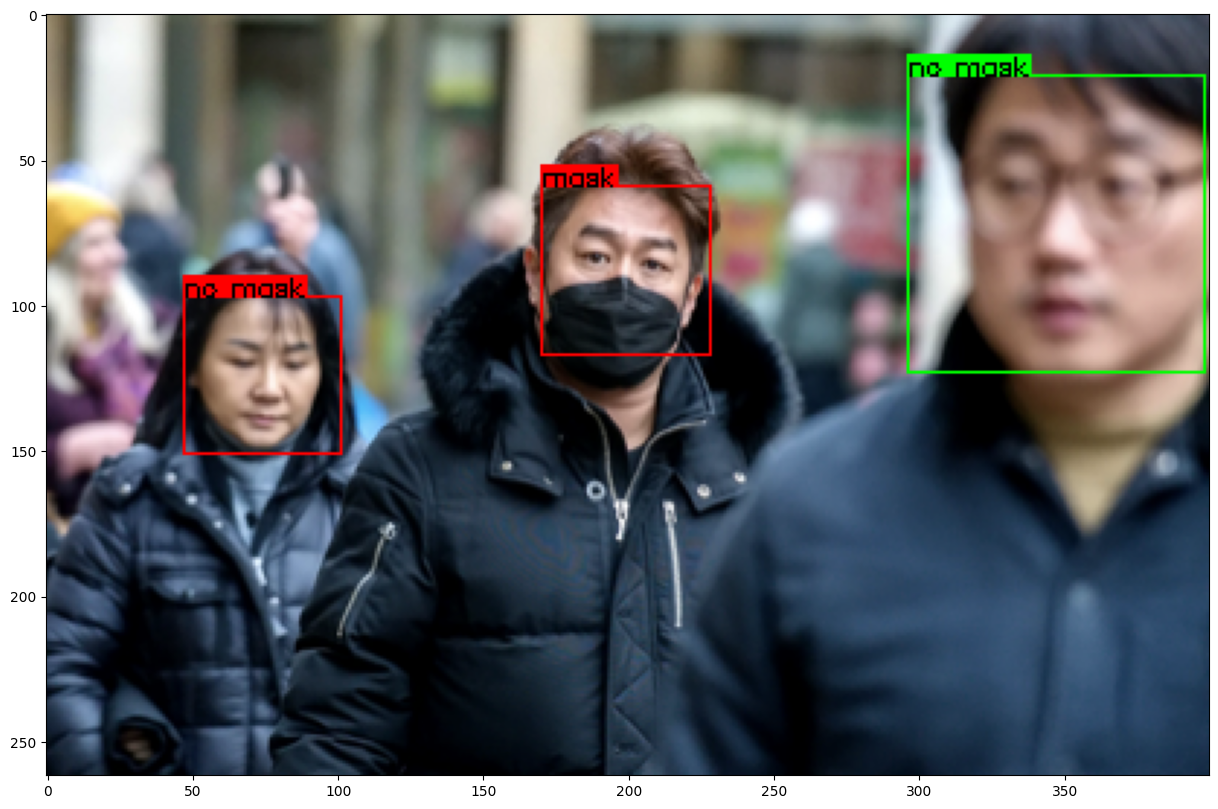

In [23]:
mask_label = {1:'mask',0:'no mask'}
dist_label = {0:(0,255,0),1:(255,0,0)}
transform = transforms.Compose([
                    transforms.ToPILImage(),                    
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        #print(crop.shape())
        crop = transform(crop)
        # triton input
        infer_inputs = [InferInput('input__0', crop.numpy().shape, "FP32")]
        infer_inputs[0].set_data_from_numpy(crop.numpy())
        # Perform inference using Triton client
        infer_outputs = [InferRequestedOutput('output__0')]  # Replace '34' with the appropriate output layer name
        response = triton_client.infer(model_name=model_info['name'], inputs=infer_inputs, model_version = model_info['version'], outputs=infer_outputs)

        mask_result = response.as_numpy('output__0')
    
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1) # object frame
        label_f = mask_label[np.argmax(mask_result, 1).item()]
        fontFace = cv2.FONT_HERSHEY_SIMPLEX                          
        fontScale = 0.3
        thickness = 1
        labelSize = cv2.getTextSize(label_f, fontFace, fontScale, thickness)
        _x1 = x # bottomleft x of text
        _y1 = y # bottomleft y of text
        _x2 = x+labelSize[0][0] # topright x of text
        _y2 = y-labelSize[0][1] # topright y of text
        # print(x,y,w,h)
        # print(_x1,_y1,_x2,_y2)
        # print(labelSize)
        cv2.rectangle(new_img, (_x1,_y1), (_x2,_y2), dist_label[label[i]], cv2.FILLED) # text backgroun
        cv2.putText(new_img, label_f,(x, y), fontFace, fontScale ,(0,0,0), thickness)
        
        
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")